# EDA & Modeling

In [78]:
random_state = 42

## Package loading

In [79]:
from modules.ezs_func import *
from modules.ezs_model import *
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import re
import math
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.neighbors import LocalOutlierFactor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.inspection import permutation_importance
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import set_config
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from pandas.api.types import is_numeric_dtype
from itertools import product
from joblib import dump
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer


## Project name

In [80]:
name = 'Franck-Hertz'

# Exploratory Data Analysis 

## Thresholds & other parameters

In [81]:
problem_type = 'regression'

In [82]:
data_size = 'small'

In [83]:
threshold_NaN = 0.5

In [84]:
threshold_cat = 5

In [85]:
threshold_Z = 3.0

In [86]:
test_size = 0.33

In [87]:
threshold_entropy = 0.75

In [88]:
undersampling = False

In [89]:
undersampler = 'Random'

In [90]:
threshold_corr = 1.0

In [91]:
threshold_model = 5

In [92]:
threshold_score = 0.4

In [93]:
threshold_feature = 5

In [94]:
with_keras = False

In [95]:
CPU = False

In [96]:
time_dep = False

In [97]:
date_idx = 0

In [98]:
lag_number = 3

In [99]:
level_1_model = 'regression'

## File & target

In [100]:
path = '/home/fifi/Documents/ezstacking/dataset/Franck-Hertz.csv'

In [101]:
df = pd.read_csv(path)

In [102]:
target_col = 'I'

### Deployment

In [103]:
FastAPI_port = 8000

In [104]:
Docker_port = 80

# Drop user's columns & Duplicates:

In [105]:
user_drop_cols = []

Dataset before deletion

In [106]:
display(df)

V     I
0     0.7  0.00
1     0.8  0.00
2     0.9  0.00
3     1.0  0.00
4     7.8  0.00
..    ...   ...
150  66.3  0.94
151  66.4  0.93
152  66.5  0.92
153  66.7  0.91
154  67.0  0.90

[155 rows x 2 columns]

In [107]:
df = df.drop(user_drop_cols, axis=1)

Duplicate rows:

In [108]:
df = duplicates(df)

No duplicate rows.


Dataset after deletion of user’s columns and duplicates

In [109]:
display(df)

V     I
0     0.7  0.00
1     0.8  0.00
2     0.9  0.00
3     1.0  0.00
4     7.8  0.00
..    ...   ...
150  66.3  0.94
151  66.4  0.93
152  66.5  0.92
153  66.7  0.91
154  67.0  0.90

[155 rows x 2 columns]

### Dataset copy

In [110]:
df_copy = df.copy()

# Dataset Information

### Dataframe structure

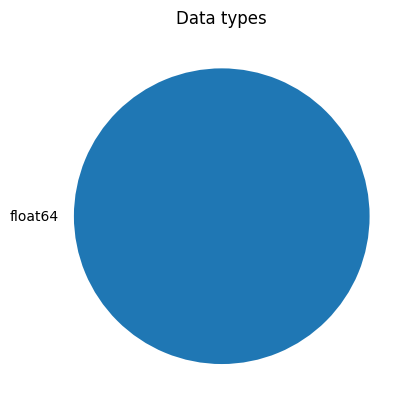

In [111]:
plot_dataframe_structure(df)

### Dataframe statistics

In [112]:
display(df.describe().T)

count       mean        std  min    25%    50%    75%    max
V  155.0  43.583871  16.147464  0.7  35.65  47.70  55.70  67.00
I  155.0   0.344645   0.241852  0.0   0.18   0.29   0.48   0.97

### Which columns could be categorical ?

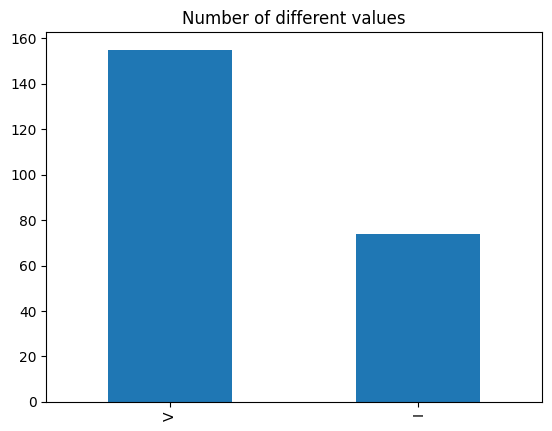

In [113]:
plot_categorical(df)

# Dataset Cleaning

### Drop NaN:

In [114]:
df, drop_cols = drop_na(df, threshold_NaN)

No need to drop columns.


Set of dropped columns: NaN

In [115]:
dropped_cols = np.unique(np.concatenate((drop_cols, user_drop_cols)))

In [116]:
display(dropped_cols)

array([], dtype=float64)

### Encoding data:

In [117]:
df, encoded_cols = encoding(df, threshold_cat, target_col)

Encoding numeric column: V
Encoding numeric column: I


### Imputing NaN using IterativeImputer

#### Imputation

In [118]:
df = imputation(df)

No need to impute data.


### Data compression:

In [119]:
df = downcast_dtypes(df)

Memory usage of dataframe is 0.00MB
Memory usage after optimization is: 0.00MB
Decreased by 71.3%


#### Dataframe structure after compression

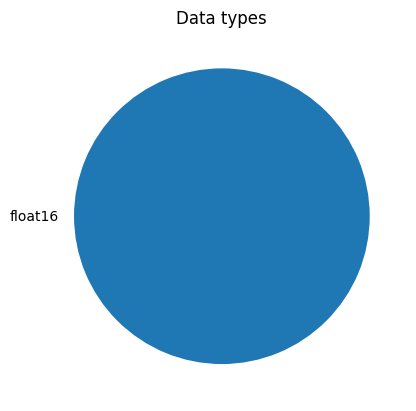

In [120]:
plot_dataframe_structure(df)

### Outliers:

In [121]:
df = outliers(df, threshold_Z)

Using Z_score,  0  rows will be suppressed.


# Correlation according to Pearson

In [122]:
corr = df.corr() 
corr.style.background_gradient(cmap='coolwarm')

In [123]:
correlated_features = correlated_columns(df, threshold_corr, target_col) 
dropped_cols = np.unique(np.concatenate((drop_cols, correlated_features)))

### Check columns that should be dropped

In [124]:
print(dropped_cols)

[]


# Splittings 

In [125]:
df = df_copy

## Splitting dataframe in features and targets

In [126]:
y = df[target_col]

In [127]:
X = df.drop(target_col, axis=1)

## Dimensions

In [128]:
nb_features = len(X.columns.tolist())

In [129]:
nb_targets = 1

In [130]:
layer_size = nb_features + nb_targets + 2

## Splitting data in train and test sets 

In [131]:
X_train, X_test, y_train, y_test = split(X, y, test_size=test_size, threshold_entropy=threshold_entropy, undersampling=undersampling, undersampler=undersampler, random_state=random_state)

# Modeling

## Model building

### Pipeline building

#### Select the categorical and numerical columns

In [132]:
cat_selector = make_column_selector(dtype_include=object)

In [133]:
num_selector = make_column_selector(dtype_include=np.number)

#### For models based on tree

In [134]:
cat_tree_processor = make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))

In [135]:
num_tree_processor = make_pipeline(IterativeImputer(random_state=random_state, add_indicator=True))

In [136]:
tree_preprocessor = make_column_transformer((num_tree_processor, num_selector), (cat_tree_processor, cat_selector))

#### For models not based on tree

In [137]:
cat_ntree_processor = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore', sparse_output=False))

In [138]:
num_ntree_processor = make_pipeline(IterativeImputer(random_state=random_state, add_indicator=True), StandardScaler())

In [139]:
ntree_preprocessor = make_column_transformer((num_ntree_processor, num_selector), (cat_ntree_processor, cat_selector))

#### Level-0 models

In [140]:
level_0 = [ 
          ('GPRL', make_pipeline(ntree_preprocessor, GaussianProcessRegressor(kernel = ConstantKernel() * DotProduct() + ConstantKernel() + WhiteKernel(), random_state = random_state))), 
          ('GPRR', make_pipeline(ntree_preprocessor, GaussianProcessRegressor(kernel = ConstantKernel() * RBF() + ConstantKernel() + WhiteKernel(), random_state = random_state))), 
          ('GPRQ', make_pipeline(ntree_preprocessor, GaussianProcessRegressor(kernel = ConstantKernel() * RationalQuadratic() + ConstantKernel() + WhiteKernel(), random_state = random_state))), 
          ('DTRF', make_pipeline(tree_preprocessor, DecisionTreeRegressor(criterion='friedman_mse', random_state = random_state))), 
          ('DTRA', make_pipeline(tree_preprocessor, DecisionTreeRegressor(criterion='absolute_error', random_state = random_state))), 
          ('DTRP', make_pipeline(tree_preprocessor, DecisionTreeRegressor(criterion='poisson', random_state = random_state))), 
          ('RFRS', make_pipeline(tree_preprocessor, RandomForestRegressor(criterion='squared_error', n_estimators=100, random_state = random_state))), 
          ('RFRA', make_pipeline(tree_preprocessor, RandomForestRegressor(criterion='absolute_error', n_estimators=100, random_state = random_state))), 
          ('RFRP', make_pipeline(tree_preprocessor, RandomForestRegressor(criterion='poisson', n_estimators=100, random_state = random_state))), 
          ('HGBR', make_pipeline(tree_preprocessor, HistGradientBoostingRegressor(early_stopping=True, random_state = random_state))), 
          ('ELNE', make_pipeline(ntree_preprocessor, ElasticNet(alpha=0.01, l1_ratio=0.15, random_state = random_state))), 
          ('ELNECV', make_pipeline(ntree_preprocessor, ElasticNetCV(cv=5, random_state = random_state))), 
          ('LINR', make_pipeline(ntree_preprocessor, LinearRegression())), 
          ('KNRU', make_pipeline(ntree_preprocessor, KNeighborsRegressor(weights='uniform'))), 
          ('KNRD', make_pipeline(ntree_preprocessor, KNeighborsRegressor(weights='distance'))), 
          ('SVRL', make_pipeline(ntree_preprocessor, SVR(kernel='linear'))), 
          ('SVRP', make_pipeline(ntree_preprocessor, SVR(kernel='poly'))), 
          ('SVRG', make_pipeline(ntree_preprocessor, SVR(kernel='rbf'))), 
          ]

#### Level-1 model

In [141]:
level_1 = LinearRegression()

#### Stacking for regression

In [142]:
model = StackingRegressor(level_0, final_estimator=level_1, n_jobs=-1)

# Model fitting

In [143]:
%%time 
set_config(display='diagram') 
model.fit(X_train, y_train)

/home/fifi/anaconda3/envs/ezstacking/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/fifi/anaconda3/envs/ezstacking/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/fifi/anaconda3/envs/ezstacking/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


CPU times: user 264 ms, sys: 12.6 ms, total: 277 ms
Wall time: 4.46 s


StackingRegressor(estimators=[('GPRL',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('pipeline-1',
                                                                                 Pipeline(steps=[('iterativeimputer',
                                                                                                  IterativeImputer(add_indicator=True,
                                                                                                                   random_state=42)),
                                                                                                 ('standardscaler',
                                                                                                  StandardScaler())]),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f937ef8f730>),
                                                                                ('pipeline-2',
                                                                                 Pipel...
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f937ef8f730>),
                                                                                ('pipeline-2',
                                                                                 Pipeline(steps=[('simpleimputer',
                                                                                                  SimpleImputer(strategy='most_frequent')),
                                                                                                 ('onehotencoder',
                                                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                                                sparse_output=False))]),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f937ef8f910>)])),
                                               ('svr', SVR())]))],
                  final_estimator=LinearRegression(), n_jobs=-1)

# Model evaluation

### Model scoring

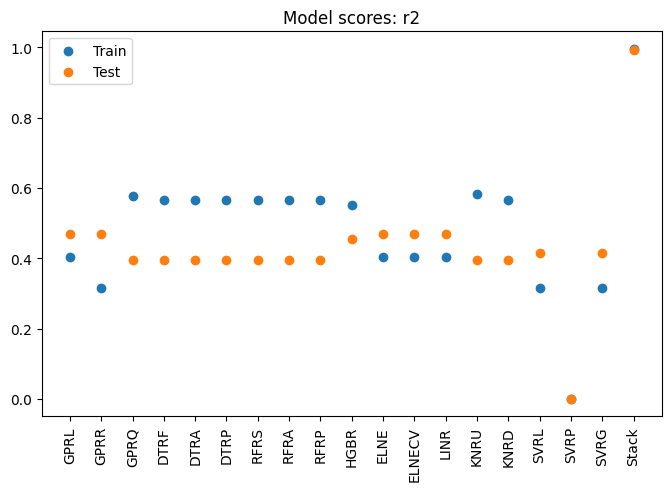

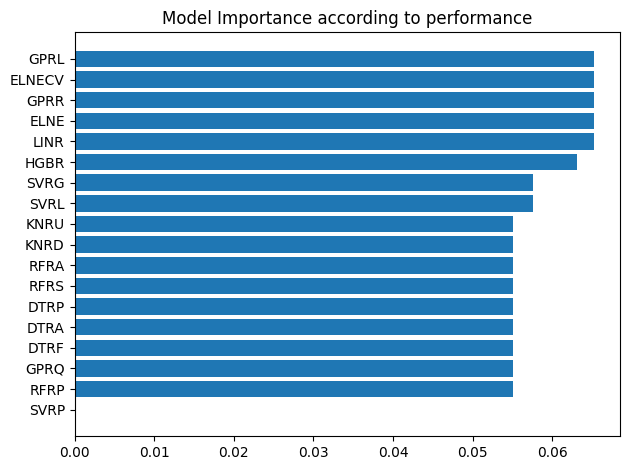

In [144]:
score_stack_0, mod_imp_score_0 = score_stacking(model, X_train, y_train, X_test, y_test)

### $R^2$ score

In [145]:
K_r2(model,X_train, y_train, X_test, y_test)

# Model inspection

### Model importance

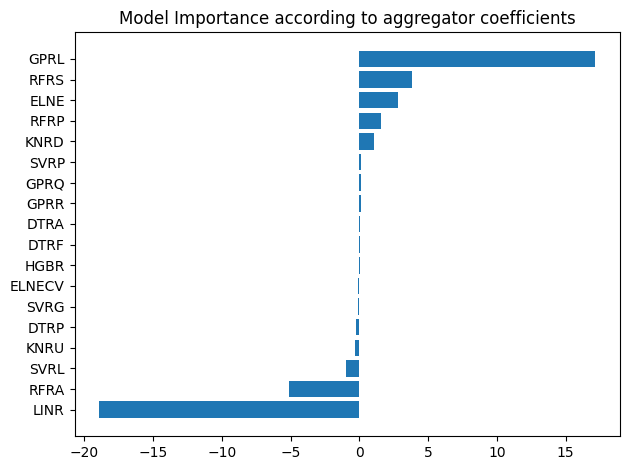

In [146]:
model_imp_0 = plot_model_importance(model, level_1_model)

### Feature permutation importance

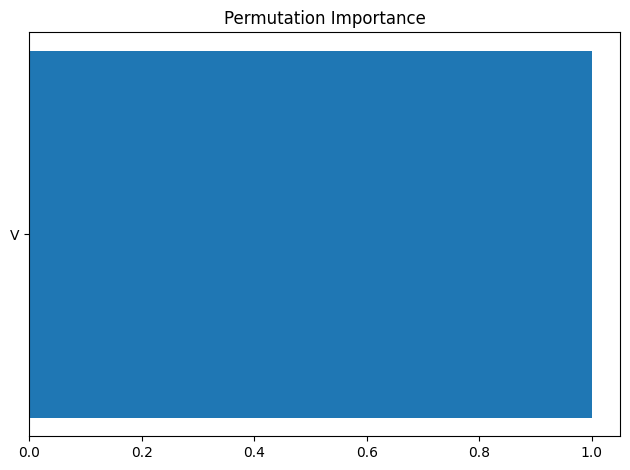

In [147]:
feature_importance_0 = plot_perm_importance(model, X_test, y_test, CPU)

# Level-0 model elimination

#### Filtered Level-0 models

In [148]:
level_0_f = model_filtering(level_0, model_imp_0, threshold_model, score_stack_0, threshold_score)

#### Level-1 model with filtration

In [149]:
level_1 = LinearRegression()

#### Build filtered model

In [150]:
model = StackingRegressor(level_0_f, final_estimator=level_1, n_jobs=-1)

# Filtered Model fitting

In [151]:
%%time 
set_config(display='diagram') 
model.fit(X_train, y_train)

CPU times: user 92.6 ms, sys: 14.3 ms, total: 107 ms
Wall time: 1.66 s


StackingRegressor(estimators=[('GPRL',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('pipeline-1',
                                                                                 Pipeline(steps=[('iterativeimputer',
                                                                                                  IterativeImputer(add_indicator=True,
                                                                                                                   random_state=42)),
                                                                                                 ('standardscaler',
                                                                                                  StandardScaler())]),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f937ef8f730>),
                                                                                ('pipeline-2',
                                                                                 Pipel...
                                                                                ('pipeline-2',
                                                                                 Pipeline(steps=[('simpleimputer',
                                                                                                  SimpleImputer(strategy='most_frequent')),
                                                                                                 ('onehotencoder',
                                                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                                                sparse_output=False))]),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f937ef8f910>)])),
                                               ('elasticnetcv',
                                                ElasticNetCV(cv=5,
                                                             random_state=42))]))],
                  final_estimator=LinearRegression(), n_jobs=-1)

# Filtered Model evaluation

### Filtered Model scoring

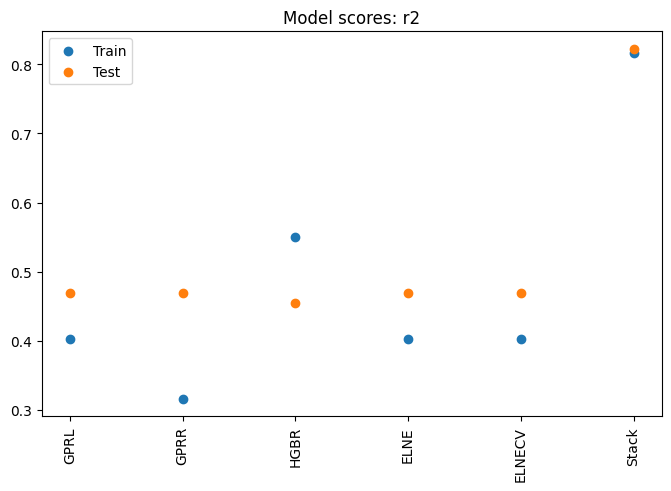

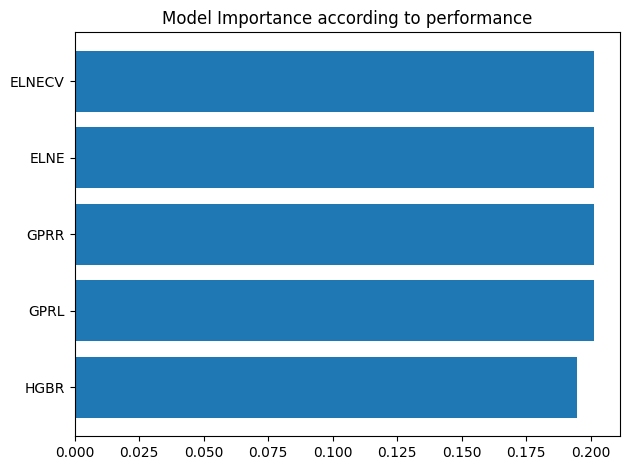

In [152]:
score_stack_1, mod_imp_score_1 = score_stacking(model, X_train, y_train, X_test, y_test)

### Filtered $R^2$ score

In [153]:
K_r2(model,X_train, y_train, X_test, y_test)

# Filtered Model inspection

### Filtered Model importance

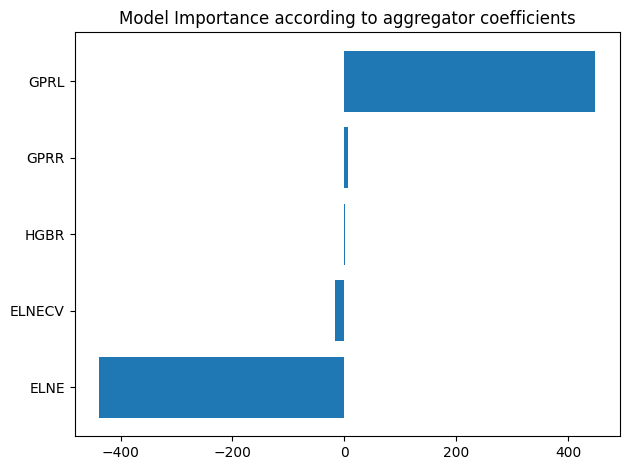

In [154]:
model_imp_1 = plot_model_importance(model, level_1_model)

### Filtered feature permutation importance

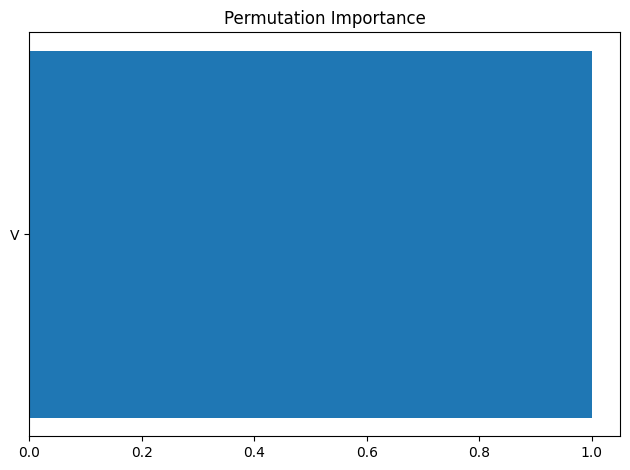

In [155]:
feature_importance_1 = plot_perm_importance(model, X_test, y_test, CPU)

#### Filtered feature elimination

In [156]:
best_feature, worst_feature = feature_filtering(feature_importance_1, threshold_feature)

In [157]:
dropped_cols = np.unique(np.concatenate((dropped_cols, worst_feature))).tolist()

### Check those columns, they should be dropped

In [158]:
print(dropped_cols)

[]


# Final Model

In [159]:
df = df_copy.drop(dropped_cols, axis=1, errors='ignore')

In [160]:
reduce_schema('column_name', dropped_cols)

# Splitting

In [161]:
y = df[target_col] 

In [162]:
X = df.drop(target_col, axis=1) 

## Dimensions

In [163]:
nb_features = len(X.columns.tolist()) 

In [164]:
nb_targets = 1 

In [165]:
layer_size = nb_features + nb_targets + 2 

## Splitting data in train and test sets 

In [166]:
X_train, X_test, y_train, y_test = split(X, y, test_size=test_size, threshold_entropy=threshold_entropy, undersampling= undersampling, undersampler= undersampler, random_state = random_state) 

In [167]:
threshold_score = 0.7

#### Build final model

In [168]:
model = StackingRegressor(level_0_f, final_estimator=level_1, n_jobs=-1)

# Final Model fitting

In [169]:
%%time 
set_config(display='diagram') 
model.fit(X_train, y_train)

CPU times: user 116 ms, sys: 4.94 ms, total: 121 ms
Wall time: 1.67 s


StackingRegressor(estimators=[('GPRL',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('pipeline-1',
                                                                                 Pipeline(steps=[('iterativeimputer',
                                                                                                  IterativeImputer(add_indicator=True,
                                                                                                                   random_state=42)),
                                                                                                 ('standardscaler',
                                                                                                  StandardScaler())]),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f937ef8f730>),
                                                                                ('pipeline-2',
                                                                                 Pipel...
                                                                                ('pipeline-2',
                                                                                 Pipeline(steps=[('simpleimputer',
                                                                                                  SimpleImputer(strategy='most_frequent')),
                                                                                                 ('onehotencoder',
                                                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                                                sparse_output=False))]),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f937ef8f910>)])),
                                               ('elasticnetcv',
                                                ElasticNetCV(cv=5,
                                                             random_state=42))]))],
                  final_estimator=LinearRegression(), n_jobs=-1)

# Final Model evaluation

### Final Model scoring

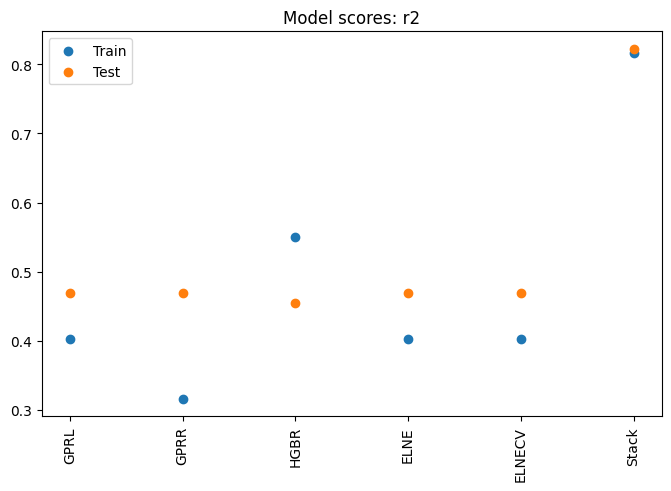

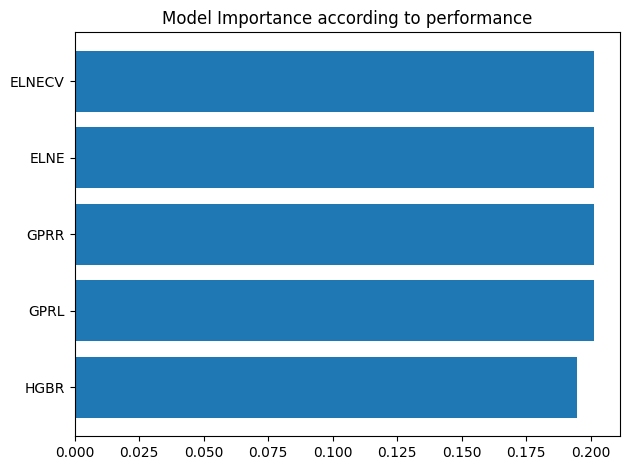

In [170]:
score_stack_2, mod_imp_score_2 = score_stacking(model, X_train, y_train, X_test, y_test)

### Final feature permutation importance

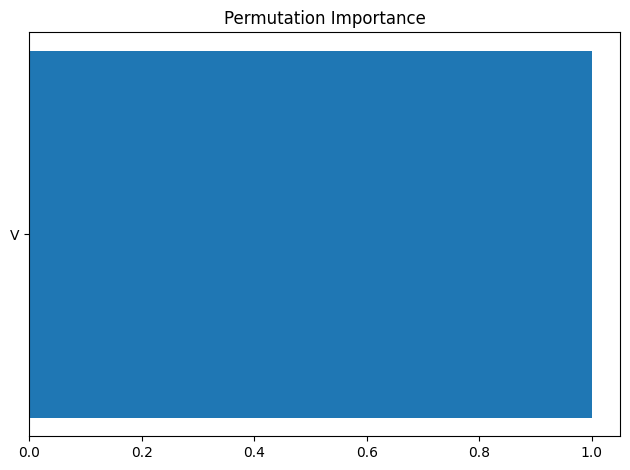

In [171]:
feature_importance_2 = feature_importance = plot_perm_importance(model, X_test, y_test, CPU)

#### Final feature elimination

In [172]:
best_feature, worst_feature = feature_filtering(feature_importance_2, threshold_feature)

### Final $R^2$ score

In [173]:
K_r2(model,X_train, y_train, X_test, y_test)

# Final Model inspection

### Final Model importance

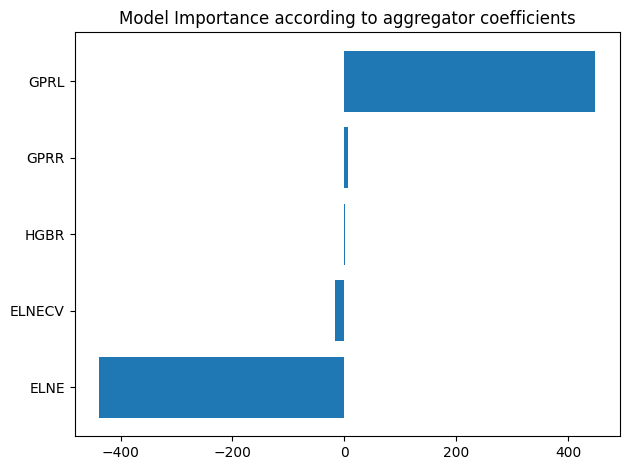

In [174]:
model_imp_2 = plot_model_importance(model, level_1_model)

### Final Feature permutation importance

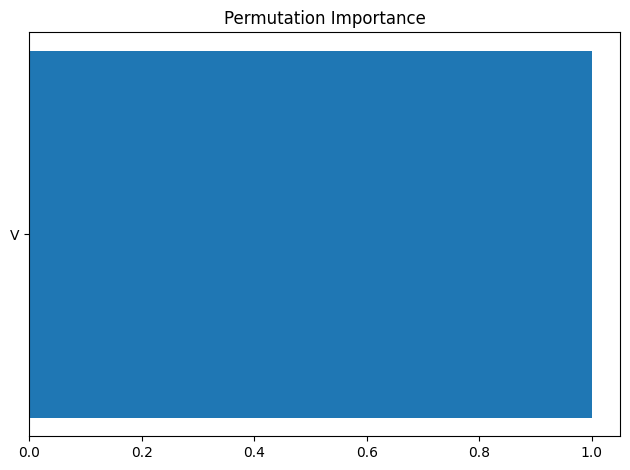

array([['V', 1.0]], dtype=object)

In [175]:
plot_perm_importance(model, X_test, y_test, CPU)

### Final Partial Dependence & Individual Conditional Expectation 

In [176]:
pd_ice_plot(model=model, X=X_test, feature=X_test.columns.tolist(), CPU=CPU)

interactive(children=(Dropdown(description='feature', options=('V',), value='V'), Output()), _dom_classes=('wi…

# Deployment

## Save your model

In [177]:
model_name = 'model.sav' 
dump(model, model_name)

['model.sav']

## Generate your server

In [178]:
fastapi_server(model, 'model.sav', X, y, FastAPI_port, with_keras)

## [Test your API](./server.ipynb)

## Docker

In [179]:
dockerize(name, model, model_name, X, y, Docker_port, with_keras)